In [1]:
import json

import h5py
import numba
import numpy as np

from utils.measure_and_compare import measure_and_compare, reset_measure_and_compare

reset_measure_and_compare()

In [2]:
def load_data_hdf5(path):
    segments = []
    counts = []
    centers = []
    covs = []
    for hdf5_path in sorted(path.glob("*.hdf5"), key=lambda p: int(p.stem)):
        with h5py.File(hdf5_path, "r") as f:
            segments.append(f["segments"][:])
            counts.append(f["counts"][:])
            centers.append(f["centers"][:])
            covs.append(f["covs"][:])
    return segments, counts, centers, covs


def combine_stats_per_segment(covs, means, sizes):
    reshaped_sizes = sizes.reshape((-1, 1, 1))
    sizes_sum = sizes.sum()

    # bias correction
    corrected_covs = covs * ((reshaped_sizes - 1) / reshaped_sizes).astype(covs.dtype)

    e = corrected_covs + means.reshape(
        (means.shape[0], means.shape[1], 1)
    ) * means.reshape((means.shape[0], 1, means.shape[1]))
    new_e = (e * reshaped_sizes).sum(axis=(0)) / sizes_sum
    new_mean = (means * sizes.reshape((-1, 1))).sum(0) / sizes_sum
    new_cov = new_e - np.outer(new_mean, new_mean)

    # bias correction
    new_cov = new_cov * sizes_sum / (sizes_sum - 1)

    return sizes_sum, new_mean, new_cov


def combine_stats(chunked_stats):
    concated_stats = tuple(
        map(lambda x: np.concatenate([i for i in x if len(i) > 0]), chunked_stats)
    )
    sort_idx = np.argsort(concated_stats[0])
    all_segments = concated_stats[0][sort_idx]
    all_counts = concated_stats[1][sort_idx]
    all_centers = concated_stats[2][sort_idx]
    all_covs = concated_stats[3][sort_idx]
    g_segments, g_idx = np.unique(all_segments, return_index=True)
    g_counts = np.split(all_counts, g_idx[1:])
    g_centers = np.split(all_centers, g_idx[1:])
    g_covs = np.split(all_covs, g_idx[1:])

    def empty_array(other):
        return np.ndarray((len(other),) + other[0].shape[1:], dtype=other[0].dtype)

    segments = empty_array(g_segments)
    counts = empty_array(g_counts)
    centers = empty_array(g_centers)
    covs = empty_array(g_covs)
    for i, (segment, count, center, cov) in enumerate(
        zip(g_segments, g_counts, g_centers, g_covs)
    ):
        count_i, center_i, cov_i = combine_stats_per_segment(cov, center, count)
        segments[i] = segment
        counts[i] = count_i
        centers[i] = center_i
        covs[i] = cov_i
    return np.array(segments), np.array(counts), np.array(centers), np.array(covs)


@measure_and_compare()
def load_and_combine_stats(path):
    chunked_stats = load_data_hdf5(path)
    return combine_stats(chunked_stats)

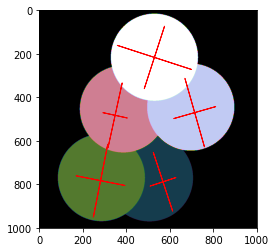

 9.32s (17.98s wall)  load_and_combine_stats(data/jit)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats__data_jit.svg

In [3]:
from pathlib import Path

from utils.preparation import get_segmentation, plot

combined_stats = load_and_combine_stats(Path("data/small"))

segmentation = get_segmentation()
plot(segmentation, combined_stats)

combined_stats = load_and_combine_stats(Path("data/jit"), max_time=25)

In [4]:
@numba.njit
def combine_stats_per_segment_jit(
    covs: np.ndarray, means: np.ndarray, sizes: np.ndarray
) -> np.ndarray:
    reshaped_sizes = sizes.reshape((-1, 1, 1))
    sizes_sum = sizes.sum()

    # bias correction
    corrected_covs = covs * ((reshaped_sizes - 1) / reshaped_sizes).astype(covs.dtype)

    e = corrected_covs + means.reshape(
        (means.shape[0], means.shape[1], 1)
    ) * means.reshape((means.shape[0], 1, means.shape[1]))
    new_e = (e * reshaped_sizes).sum(axis=(0)) / sizes_sum
    new_mean = (means * sizes.reshape((-1, 1))).sum(0) / sizes_sum
    new_cov = new_e - np.outer(new_mean, new_mean)

    # bias correction
    new_cov = new_cov * sizes_sum / (sizes_sum - 1)

    return sizes_sum, new_mean, new_cov


def combine_stats_jit(chunked_stats):
    segments = []
    counts = []
    centers = []
    covs = []
    concated_stats = tuple(
        map(lambda x: np.concatenate([i for i in x if len(i) > 0]), chunked_stats)
    )
    sort_idx = np.argsort(concated_stats[0])
    all_segments = concated_stats[0][sort_idx]
    all_counts = concated_stats[1][sort_idx]
    all_centers = concated_stats[2][sort_idx]
    all_covs = concated_stats[3][sort_idx]
    g_segments, g_idx = np.unique(all_segments, return_index=True)
    g_counts = np.split(all_counts, g_idx[1:])
    g_centers = np.split(all_centers, g_idx[1:])
    g_covs = np.split(all_covs, g_idx[1:])
    for segment, count, center, cov in zip(g_segments, g_counts, g_centers, g_covs):
        count_i, center_i, cov_i = combine_stats_per_segment_jit(cov, center, count)
        segments.append(segment)
        counts.append(count_i)
        centers.append(center_i)
        covs.append(cov_i)
    return np.array(segments), np.array(counts), np.array(centers), np.array(covs)


@measure_and_compare()
def load_and_combine_stats_jit(path):
    chunked_stats = load_data_hdf5(path)
    return combine_stats_jit(chunked_stats)

In [5]:
_ = load_and_combine_stats_jit(Path("data/jit"), max_time=25)
_ = load_and_combine_stats_jit(Path("data/jit"), max_time=20)

13.45s (25.87s wall) load_and_combine_stats_jit(data/jit), -30.73% faster (load_and_combine_stats was  9.32s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_jit__data_jit.svg

 8.78s (16.23s wall) load_and_combine_stats_jit(data/jit), 6.17% faster (load_and_combine_stats was  9.32s)


/home/jonathan/code/data-analysis-speedup/profiles/load_and_combine_stats_jit__data_jit.svg